In [28]:
# python librairies installation
%pip install split-folders matplotlib opencv-python spicy

Note: you may need to restart the kernel to use updated packages.


In [29]:
# display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [35]:
datagen = ImageDataGenerator()

In [36]:
# define classes name
class_names = ['apple', 'car', 'dog', 'gold', 'mobile', 'rose', 'scooter', 'tiger', 'wallet', 'watch']

In [37]:
train_generator = datagen.flow_from_directory(
    directory="/workspace/steven/EEG2Image/data/images/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",  # Use "categorical" if your labels are one-hot encoded
)

Found 534 images belonging to 10 classes.


In [38]:
valid_generator = datagen.flow_from_directory(
    directory="/workspace/steven/EEG2Image/data/images/val",  # Assuming you have a similar structure for validation
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",  # Use "categorical" if your labels are one-hot encoded
)

Found 175 images belonging to 10 classes.


In [49]:
test_generator = datagen.flow_from_directory(
    directory="/workspace/steven/EEG2Image/data/images/test",  # Assuming you have a similar structure for validation
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",  # Use "categorical" if your labels are one-hot encoded
)

Found 175 images belonging to 10 classes.


In [40]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [41]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)  # Replace `num_classes` with your actual number of classes
model = Model(inputs = resnet_50.input, outputs = predictions)

In [42]:
# Create and configure the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)

In [43]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [44]:
#  Now, launch the training with the configured optimizer
model_history = trainModel(model=model, epochs=10, optimizer=optimizer)

Epoch 1/10
17/17 [==============================] - 8s 230ms/step - loss: 3.7177 - accuracy: 0.0787 - val_loss: 2.2565 - val_accuracy: 0.1714
Epoch 2/10
17/17 [==============================] - 3s 192ms/step - loss: 3.0303 - accuracy: 0.0993 - val_loss: 2.2038 - val_accuracy: 0.2914
Epoch 3/10
17/17 [==============================] - 3s 197ms/step - loss: 2.7541 - accuracy: 0.1236 - val_loss: 2.1667 - val_accuracy: 0.3543
Epoch 4/10
17/17 [==============================] - 3s 201ms/step - loss: 2.4328 - accuracy: 0.1573 - val_loss: 2.1312 - val_accuracy: 0.4857
Epoch 5/10
17/17 [==============================] - 4s 219ms/step - loss: 2.3657 - accuracy: 0.1685 - val_loss: 2.1057 - val_accuracy: 0.5657
Epoch 6/10
17/17 [==============================] - 3s 200ms/step - loss: 2.3618 - accuracy: 0.1704 - val_loss: 2.0749 - val_accuracy: 0.6457
Epoch 7/10
17/17 [==============================] - 3s 192ms/step - loss: 2.3270 - accuracy: 0.1854 - val_loss: 2.0447 - val_accuracy: 0.7257
Epoch 

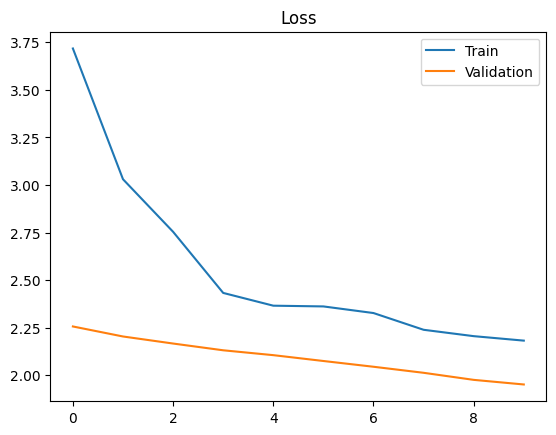

In [45]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

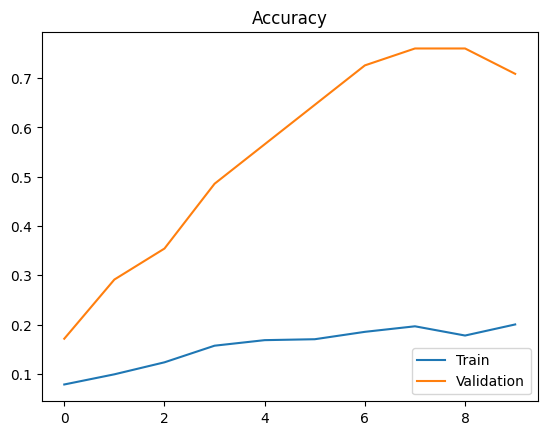

In [46]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [50]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

6/6 [==============================] - 1s 127ms/step - loss: 1.9515 - accuracy: 0.7086
The test loss is:  1.9515215158462524
The best accuracy is:  70.85714340209961


In [48]:
img = tf.keras.preprocessing.image.load_img('/workspace/steven/EEG2Image/data/images/dog.jpeg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/tulipe-test.jpeg'

In [ ]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

In [ ]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

In [ ]:
# transform classes number into classes name
class_names[class_id.item()]

### Step 7 - Save and export the model

>To save your model, you should create an other Object Storage container (with write rights) and mount it in your workspace (`saved_model` in this example).

You can now save your model in a dedicated folder.

In [ ]:
model.save('/workspace/saved_model/my_model')

In [ ]:
# my_model directory
%ls /workspace/saved_model/

In [ ]:
# contains an assets folder, saved_model.pb, and variables folder
%ls /workspace/saved_model/my_model

In [ ]:
model = tf.keras.models.load_model('/workspace/saved_model/my_model')
model.summary()

## Conclusion

**Transfer Learning** saves time by achieving better performance in fewer epochs. 

Train and test this model on your own dataset !